In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import xarray as xr
import rasterio as rio
import rioxarray
import pandas as pd

import deep_snow.models
import deep_snow.dataset
from deep_snow.utils import calc_norm, undo_norm, db_scale, calc_dowy
from deep_snow.dataset import norm_dict

In [2]:
test_tile_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/test_tiles'
test_path_list = glob(f'{test_tile_dir}/ASO_50M_SD*.nc')

In [3]:
model_path = '../../../weights/quinn_ResDepth_v10_256epochs'

In [4]:
def prep_dataset(data_fn):
    ds = xr.open_dataset(data_fn)
    # radar data variables
    # convert to decibels
    ds['snowon_vv'] = (('y', 'x'), db_scale(ds['snowon_vv']))
    ds['snowon_vh'] =  (('y', 'x'),db_scale(ds['snowon_vh']))
    ds['snowoff_vv'] =  (('y', 'x'),db_scale(ds['snowoff_vv']))
    ds['snowoff_vh'] =  (('y', 'x'),db_scale(ds['snowoff_vh']))
    
    # calculate variables
    ds['snowon_cr'] = ds['snowon_vh'] - ds['snowon_vv']
    ds['snowoff_cr'] = ds['snowoff_vh'] - ds['snowoff_vv']
    ds['delta_cr'] = ds['snowon_cr'] - ds['snowoff_cr']

    ds['ndvi'] = (ds['B08'] - ds['B04'])/(ds['B08'] + ds['B04'])
    ds['ndsi'] = (ds['B03'] - ds['B11'])/(ds['B03'] + ds['B11'])
    ds['ndwi'] = (ds['B03'] - ds['B08'])/(ds['B03'] + ds['B08'])

    # dowy
    dowy_1d = calc_dowy(pd.to_datetime(data_fn.split('_')[5]).dayofyear)
    ds['dowy'] = (('y', 'x'), np.full_like(ds['latitude'], dowy_1d))

    return ds

In [5]:
def apply_model(ds, model, input_channels):
    ds = ds.fillna(0)

    data_dict = {}
    # normalize layers 
    data_dict['snowon_vv'] = calc_norm(torch.Tensor(ds['snowon_vv'].values), norm_dict['vv'])
    data_dict['delta_cr'] = calc_norm(torch.Tensor(ds['delta_cr'].values), norm_dict['delta_cr'])
    data_dict['green'] = calc_norm(torch.Tensor(ds['B03'].values), norm_dict['green'])
    data_dict['swir2'] = calc_norm(torch.Tensor(ds['B12'].values), norm_dict['swir2'])
    data_dict['ndsi'] = calc_norm(torch.Tensor(ds['ndsi'].values), [-1, 1])
    data_dict['ndwi'] = calc_norm(torch.Tensor(ds['ndwi'].values), [-1, 1])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])

    # clamp values, add dimensions
    data_dict = {key: torch.clamp(data_dict[key], 0, 1)[None, None, :, :] for key in data_dict.keys()}
    inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

    # predict noise in tile
    with torch.no_grad():
        pred_sd = model(inputs.to('cuda'))
    pred_sd = pred_sd.detach().squeeze()
    
    # undo normalization
    pred_sd = undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd'])
    # add to xarray dataset
    ds['predicted_sd'] = (('y', 'x'), pred_sd.to('cpu').numpy())
    ds['predicted_sd'] = ds['predicted_sd'].where(ds['predicted_sd'] > 0, 0)
    
    return ds

In [6]:
 # define input channels for model
input_channels = [
    'snowon_vv',
    'delta_cr',
    'green',
    'swir2',
    'ndsi',
    'ndwi',
    'elevation',
    'latitude',
    'longitude']

model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load(model_path))
model.to('cuda');

/tmp/ipykernel_26325/18857335.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [7]:
accuracy_list = ['aso_sd', 'predicted_sd', 'fcf', 'elevation', 'slope', 'aspect', 'dowy', 'snow_class', 'mtn_range']

In [8]:
df = None

for i, tile_path in enumerate(test_path_list):
    ds = prep_dataset(tile_path)
    ds = ds.isel(x=slice(0, 640), y=slice(0, 640))
    ds = apply_model(ds, model, input_channels)
    ds['all_gaps'] = ds['aso_gap_map'] + ds['rtc_gap_map'] + ds['s2_gap_map']
    ds = ds.where(ds.all_gaps == 0, drop=True)
    tile_df = ds[accuracy_list].to_dataframe().reset_index()
    tile_df = tile_df.dropna(subset=['aso_sd'])
    tile_df = tile_df.drop(columns=['y', 'x', 'band', 'spatial_ref'])
    if df is None:
        df = tile_df
    else:
        df = pd.concat([df, tile_df], ignore_index=True)

In [9]:
df['error'] = df.aso_sd - df.predicted_sd
df['abs_error'] = df.error.abs()

In [10]:
# Calculate metrics
r2 = r2_score(df.aso_sd, df.predicted_sd)
mse = mean_squared_error(df.aso_sd, df.predicted_sd)
mae = mean_absolute_error(df.aso_sd, df.predicted_sd)
pearson_r, _ = pearsonr(df.aso_sd, df.predicted_sd)

print(f'R²: {r2}')
print(f'pearson r: {pearson_r}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R²: 0.8156134486198425
pearson r: 0.9128323760537728
MSE: 0.4303849935531616
MAE: 0.3858310878276825


In [262]:
aso_sd_clean = df.aso_sd.where(df.aso_sd < 5).dropna()
predicted_sd_clean = df.predicted_sd.where(df.aso_sd < 5).dropna()

# Calculate metrics
r2 = r2_score(aso_sd_clean, predicted_sd_clean)
mse = mean_squared_error(aso_sd_clean, predicted_sd_clean)
mae = mean_absolute_error(aso_sd_clean, predicted_sd_clean)
pearson_r, _ = pearsonr(aso_sd_clean, predicted_sd_clean)

print(f'R²: {r2}')
print(f'pearson r: {pearson_r}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R²: 0.8209306001663208
pearson r: 0.9132810136831697
MSE: 0.3336487412452698
MAE: 0.35802456736564636


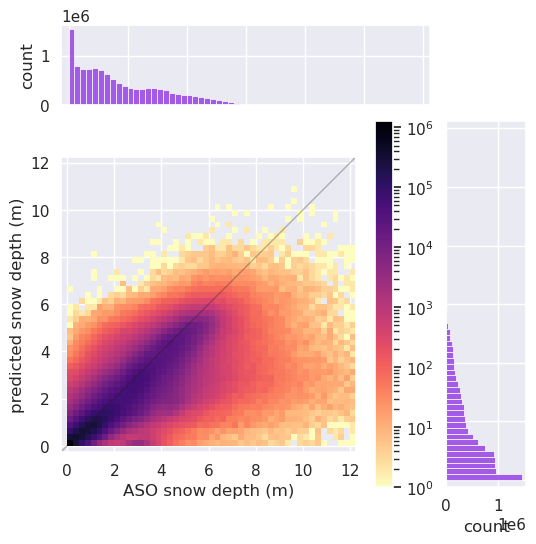

In [240]:
sns.set_theme()
axmin = -0.25
axmax = 12.25

# Create a grid layout
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(5, 5, hspace=0.2, wspace=0.2)
ax_main = fig.add_subplot(gs[1:5, 0:4])
ax_histx = fig.add_subplot(gs[0, 0:4])
ax_histy = fig.add_subplot(gs[1:5, 4])

# Main plot
sns.histplot(ax=ax_main, x=df.aso_sd[df.aso_sd > 0], y=df.predicted_sd[df.aso_sd > 0],
             cmap='magma_r', cbar=True, alpha=1, binwidth=0.25, vmin=None, vmax=None, norm=LogNorm())
ax_main.plot([-15, 30], [-15, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax_main.set_xlabel('ASO snow depth (m)')
ax_main.set_ylabel('predicted snow depth (m)')
ax_main.set_box_aspect(1)
ax_main.set_xlim(axmin, axmax)
ax_main.set_ylim(axmin, axmax)
ax_main.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_main.set_yticks([0, 2, 4, 6, 8, 10, 12])

ax_main.tick_params(axis='x', pad=2)
ax_main.tick_params(axis='y', pad=2)

# Histogram for x-axis (ASO snow depth)
sns.histplot(ax=ax_histx, x=df.aso_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histx.set_ylabel('count')
ax_histx.set_xlabel('')
ax_histx.set_xticklabels([])
ax_histx.set_xlim(axmin, axmax)
ax_histx.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_histx.tick_params(axis='x', pad=2)
ax_histx.tick_params(axis='y', pad=2)

# Histogram for y-axis (predicted snow depth)
sns.histplot(ax=ax_histy, y=df.predicted_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histy.set_xlabel('count')
ax_histy.set_ylabel('')
ax_histy.set_ylim(axmin, axmax)
ax_histy.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax_histy.set_yticklabels([])

ax_histy.tick_params(axis='x', pad=2)
ax_histy.tick_params(axis='y', pad=2)

#fig.tight_layout()

fig.savefig('../../../figs/quinn_ResDepthv10_256epochs_2dhist_wcbar.png', dpi=400, bbox_inches='tight')

In [205]:
merged_df.error_bias_corrected[df.aso_sd > 0].apply(nmad)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe560f4f510>>
Traceback (most recent call last):
  File "/mnt/Backups/gbrench/sw/miniconda3/envs/deep-snow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [261]:
merged_df.error_bias_corrected[merged_df.aso_sd > 0].median()
nmad(merged_df.error_bias_corrected[merged_df.aso_sd > 0])
merged_df.error_bias_corrected[merged_df.aso_sd > 0].kurtosis()

4.6077733

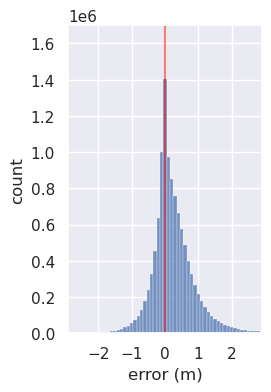

In [233]:
sns.set_theme()

f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist.png', dpi=400, bbox_inches='tight')

In [90]:
# estimate bias with snow depth
bin_width = 0.25
bins = pd.cut(df['aso_sd'], bins=pd.interval_range(-0.0001, end=df['aso_sd'].max() + bin_width, freq=bin_width))

grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()
grouped.columns = ['aso_sd_bin', 'median_bias', 'count']
# Calculate bin centers
grouped['bin_center'] = grouped['aso_sd_bin'].apply(lambda x: x.mid)

/tmp/ipykernel_26325/957875472.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()


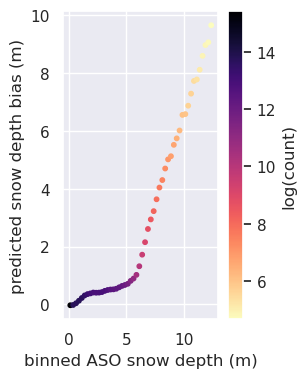

In [234]:
f, ax = plt.subplots(figsize=(2.5, 4))
scatter = ax.scatter(grouped['bin_center'][grouped['count'] >= 100], grouped['median_bias'][grouped['count'] >= 100], c=np.log(grouped['count'][grouped['count'] >= 100]), cmap='magma_r', marker='o', s=10)
f.colorbar(scatter, label='log(count)')
ax.set_xlabel('binned ASO snow depth (m)')
ax.set_ylabel('predicted snow depth bias (m)')
#ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_bias.png', dpi=400, bbox_inches='tight')

In [92]:
# Merge the original dataframe with the filtered grouped dataframe
df['aso_sd_bin'] = pd.cut(df['aso_sd'], bins=pd.interval_range(-0.0001, end=df['aso_sd'].max() + bin_width, freq=bin_width))
merged_df = pd.merge(df, grouped[['aso_sd_bin', 'median_bias']], on='aso_sd_bin', how='left')

# Create a new column with the bias removed
merged_df['error_bias_corrected'] = merged_df['error'] - merged_df['median_bias']

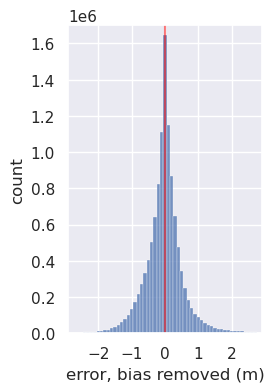

In [237]:
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(merged_df.error_bias_corrected[merged_df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error, bias removed (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist_bias_removed.png', dpi=400, bbox_inches='tight')

In [286]:
merged_df = merged_df[merged_df['aso_sd'] > 0]

/tmp/ipykernel_26325/1428226869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['sd_bins'] = pd.cut(merged_df['aso_sd'], bins=bins)


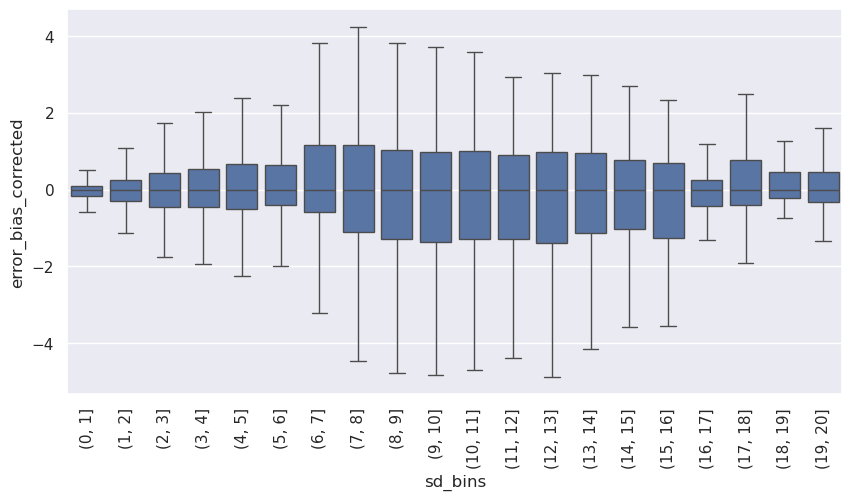

In [267]:
# snow depth
bins = np.arange(0, 21, 1)  # Define your bin edges
merged_df['sd_bins'] = pd.cut(merged_df['aso_sd'], bins=bins)

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.sd_bins, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
#ax.set_ylim(-0.05, 3)

<Axes: xlabel='slope_bins', ylabel='error_bias_corrected'>

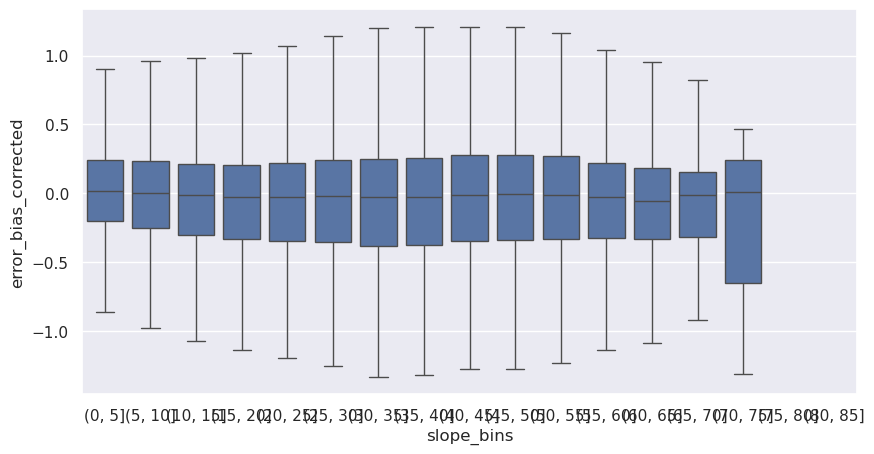

In [112]:
# slope
bins = np.arange(0, 90, 5)  # Define your bin edges
merged_df['slope_bins'] = pd.cut(merged_df['slope'], bins=bins)

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.slope_bins, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
#ax.set_ylim(-0.05, 3)

<Axes: xlabel='fcf_bins', ylabel='error_bias_corrected'>

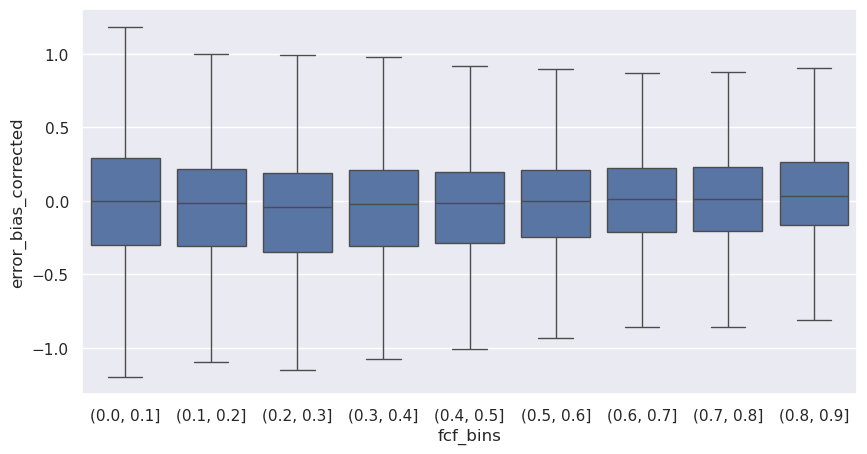

In [113]:
# fcf
# bins = np.arange(0, 1, 0.1)
# merged_df['fcf_bins'] = pd.cut(merged_df['fcf'], bins=bins)

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.fcf_bins, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
#ax.set_ylim(-0.05, 2)

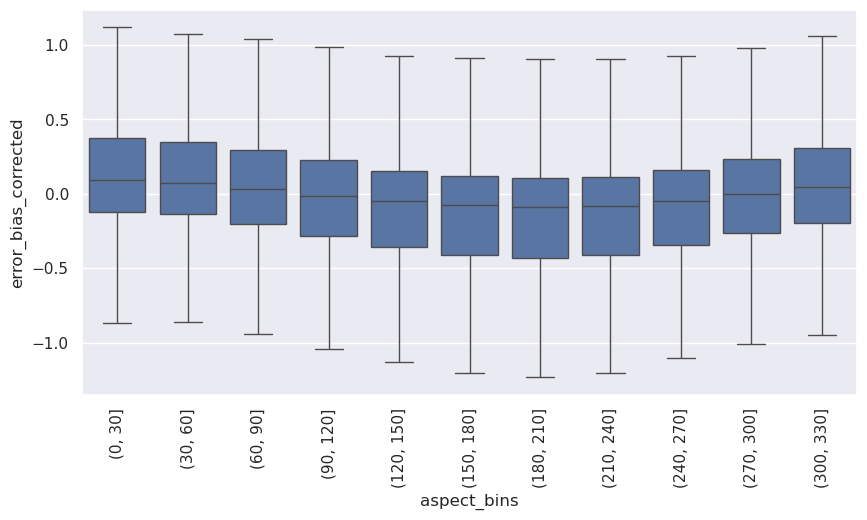

In [114]:
# aspect
# bins = np.arange(0, 360, 30)
# merged_df['aspect_bins'] = pd.cut(merged_df['aspect'], bins=bins)

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.aspect_bins, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
# ax.set_ylim(-0.05, 2)

/tmp/ipykernel_26325/2594752094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['elevation_bins'] = pd.cut(merged_df['elevation'], bins=bins)


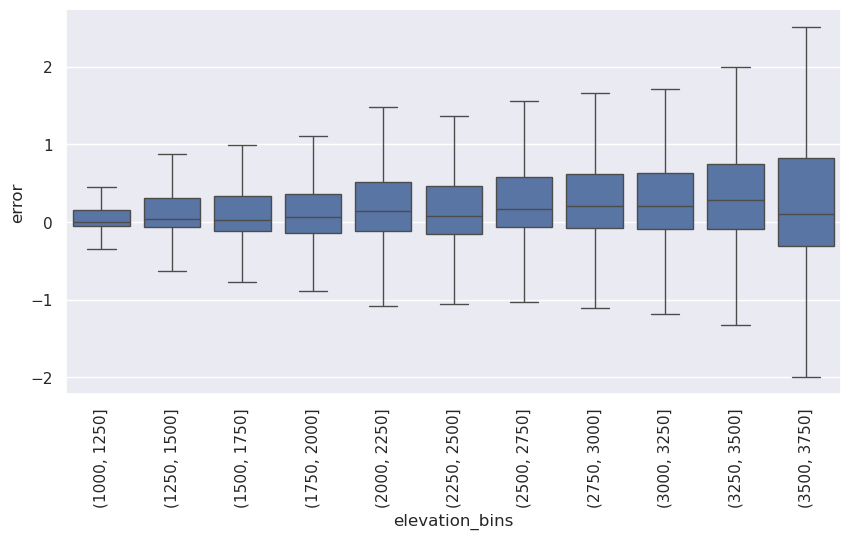

In [272]:
# elevation
bins = np.arange(1000, 4000, 250)
merged_df['elevation_bins'] = pd.cut(merged_df['elevation'], bins=bins)

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.elevation_bins, y=merged_df.error, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
# ax.set_ylim(-0.05, 2)

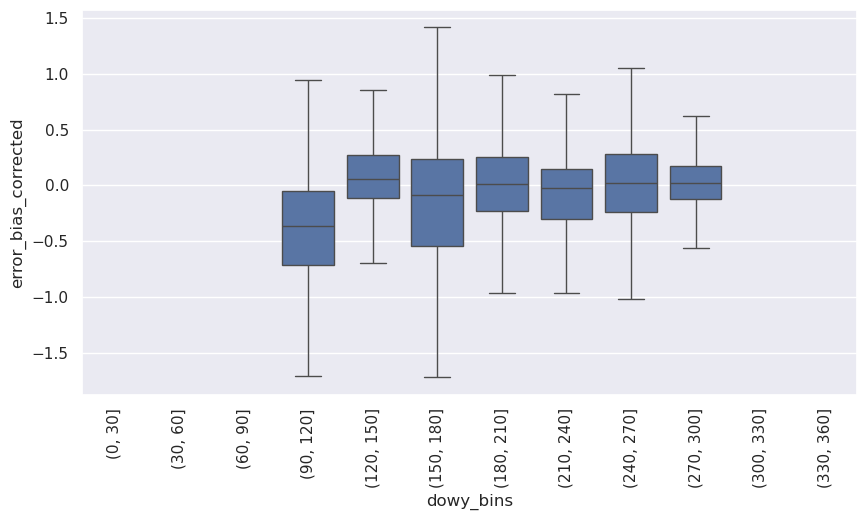

In [115]:
# dowy
# bins = np.arange(0, 365, 30)
# merged_df['dowy_bins'] = pd.cut(merged_df['dowy'], bins=bins)

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.dowy_bins, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
# ax.set_ylim(-0.05, 2)

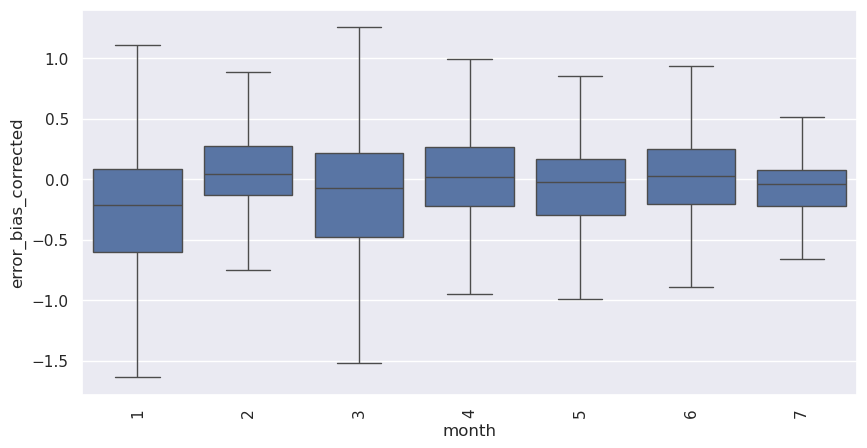

In [116]:
# dowy
# merged_df['month'] = merged_df.time.dt.month

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.month, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
# ax.set_ylim(-0.05, 2)

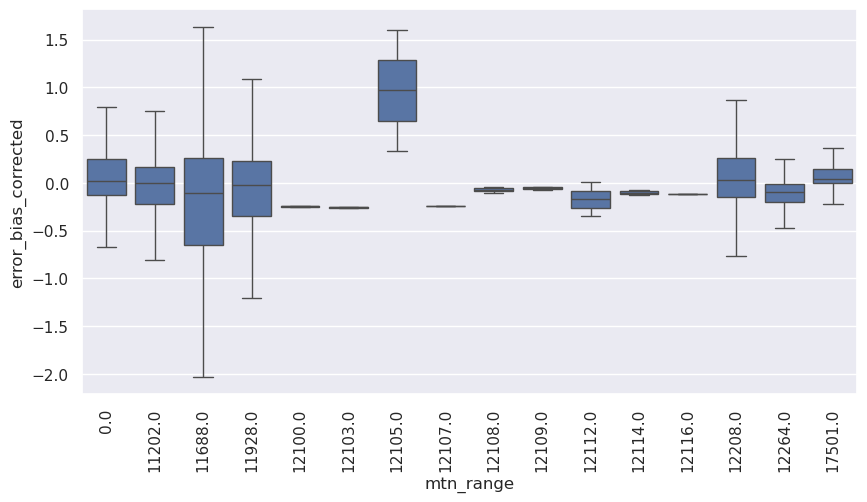

In [117]:
# merged_df['mtn_range'] = merged_df['mtn_range'].round()

# snow depth
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.mtn_range, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
#ax.set_ylim(-6, 6)

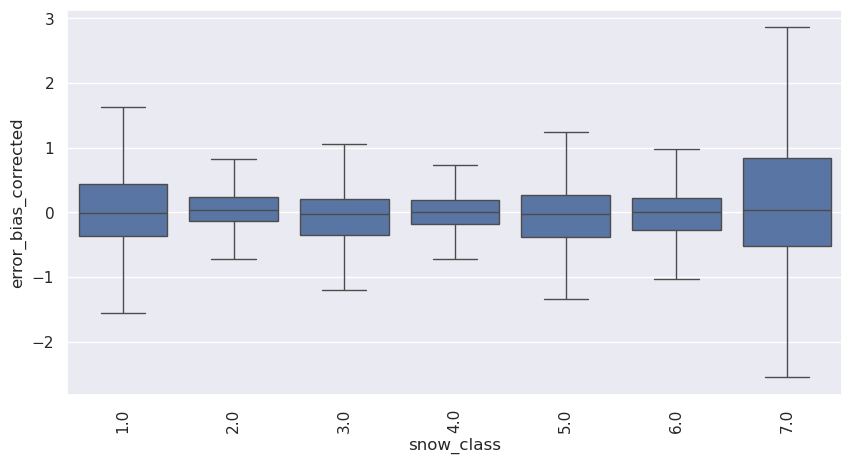

In [118]:
# merged_df['snow_class'] = merged_df['snow_class'].round()

# snow class
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=merged_df.snow_class, y=merged_df.error_bias_corrected, ax=ax, showfliers=False)
ax.tick_params(axis='x', rotation=90)
#ax.set_ylim(-6, 6)

In [121]:
def nmad(a, c=1.4826):
    return np.median(np.fabs(a - np.median(a))) * c

In [130]:
grouped_df = merged_df.groupby(['snow_class', 'month']).agg({'error_bias_corrected': [nmad, 'count']}).reset_index()
grouped_df.columns = ['snow_class', 'month', 'nmad', 'count']
heatmap_data = grouped_df.pivot(index='snow_class', columns='month', values='nmad')

<Axes: xlabel='month', ylabel='snow_class'>

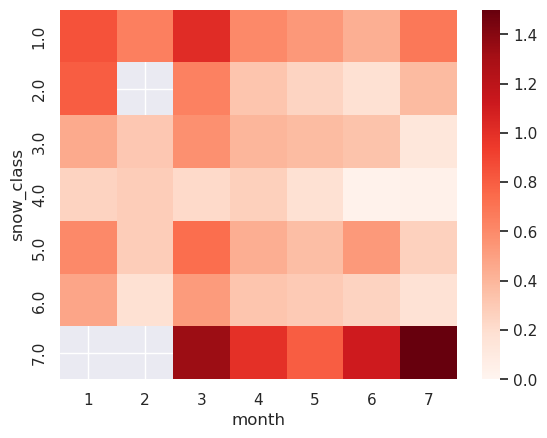

In [151]:
# snow class, month
f, ax = plt.subplots()
sns.heatmap(heatmap_data, vmin=0, vmax=1.5, cmap='Reds')

In [284]:
grouped_df = merged_df.groupby(['elevation_bins', 'sd_bins']).agg({'error_bias_corrected': [nmad, 'count']}).reset_index()
grouped_df.columns = ['elevation_bins', 'sd_bins', 'nmad', 'count']
heatmap_data = grouped_df.pivot(index='elevation_bins', columns='sd_bins', values='nmad')

/tmp/ipykernel_26325/3488041851.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = merged_df.groupby(['elevation_bins', 'sd_bins']).agg({'error_bias_corrected': [nmad, 'count']}).reset_index()


<Axes: xlabel='sd_bins', ylabel='elevation_bins'>

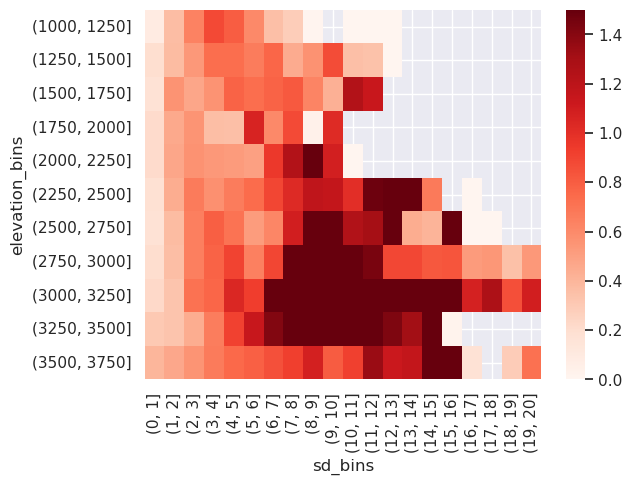

In [289]:
# snow class, slope
f, ax = plt.subplots()
sns.heatmap(heatmap_data, vmin=0, vmax=1.5, cmap='Reds')